In [1]:
# !/usr/env python3

'''
Output:
video captioning model itself and produce loss curve

Usage:
main document to train the video captioning model
'''

# set up
from __future__ import print_function
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
from util import *
from model.video_caption import sequence_2_sequence_LSTM

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# define parameters

logging.basicConfig(level=logging.INFO)
#=======Change These===============================
tf.app.flags.DEFINE_string("model_name", "baseline_1", "name of the model")
tf.app.flags.DEFINE_integer("state_size", 200, "Size of each model layer.")
tf.app.flags.DEFINE_float("learning_rate", 1e-4, "Base Learning rate.")
#==================================================

tf.app.flags.DEFINE_float("input_size", 7*7*512, "input size for each frame")
tf.app.flags.DEFINE_integer("batch_size", 50, "how many videos put per run")
tf.app.flags.DEFINE_integer("max_sentence_length", 20, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", 50, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("vocabulary_size", 22719, "vocabulary size")
tf.app.flags.DEFINE_integer("n_epochs", 10, "number of epoch to run")
tf.app.flags.DEFINE_integer("num_frames", 15, "number of frames per video")
tf.app.flags.DEFINE_integer("hidden_size", 100, "output size of LSTM encoder and decoder")
FLAGS = tf.app.flags.FLAGS        

In [3]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

curPath = os.getcwd()
dataPath = curPath + "/datasets/"

# only pick first 100 for debugging purpose
# load data
sample_size = 1000
wvector_dim = 50
is_training = True
input_frames_train, captions_train, \
        word_dict, word2Index, index2Word = load_caption_data(sample_size, dataPath, train = is_training)
word_embedding = word_embedding_array(word_dict, wvector_dim, word2Index) 
print('Finish load training data!')

Finish load training data!


In [13]:
# build model graph
tf.reset_default_graph()
model = sequence_2_sequence_LSTM(word_embedding, FLAGS)
model.build()

start building model ...
batch caption shape:  (?, 20, 22719)
batch pred shape:  (?, 20, 22719)
loss shape:  ()
total number of parameter 12430619


In [26]:
# check variables
for v in tf.trainable_variables():
    print(v)

<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/weights:0' shape=(25188, 400) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/biases:0' shape=(400,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/weights:0' shape=(150, 400) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/biases:0' shape=(400,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_word/kernel:0' shape=(100, 22719) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_word/bias:0' shape=(22719,) dtype=float32_ref>


  0%|          | 0/10 [00:00<?, ?it/s]

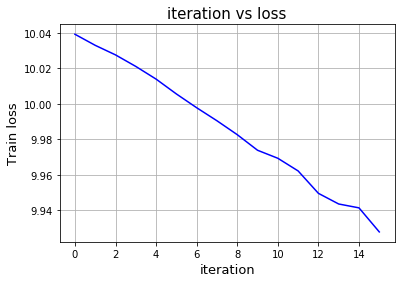

 10%|█         | 1/10 [00:12<01:55, 12.79s/it]

Epoch 0: train loss 9.986172676086426, validation loss 9.922607421875


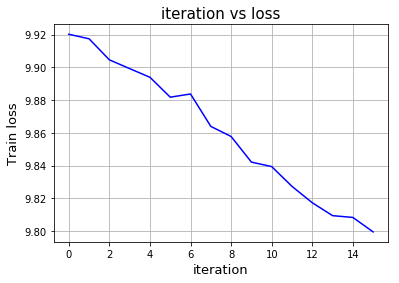

 20%|██        | 2/10 [00:24<01:40, 12.61s/it]

Epoch 1: train loss 9.860400199890137, validation loss 9.780574798583984


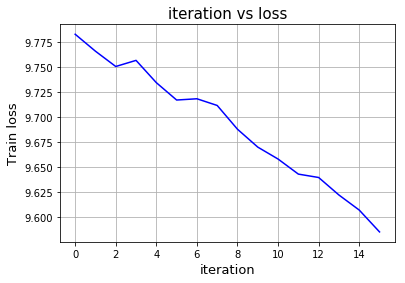

 30%|███       | 3/10 [00:36<01:26, 12.42s/it]

Epoch 2: train loss 9.690515518188477, validation loss 9.573488235473633


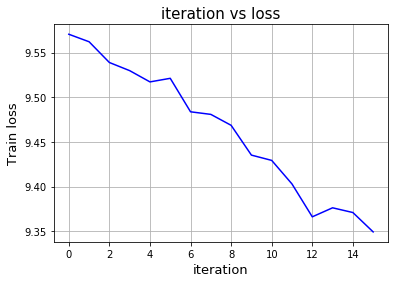

 40%|████      | 4/10 [00:49<01:13, 12.31s/it]

Epoch 3: train loss 9.462666511535645, validation loss 9.319404602050781


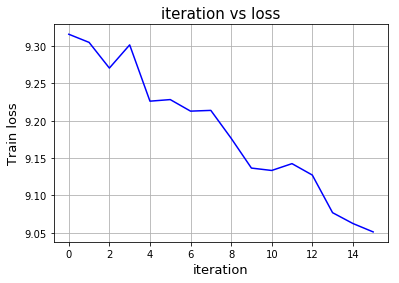

 50%|█████     | 5/10 [01:01<01:01, 12.22s/it]

Epoch 4: train loss 9.186397552490234, validation loss 9.005824089050293


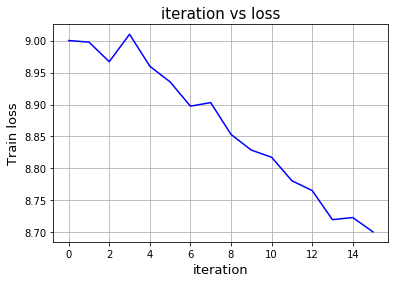

 60%|██████    | 6/10 [01:13<00:48, 12.17s/it]

Epoch 5: train loss 8.866233825683594, validation loss 8.671218872070312


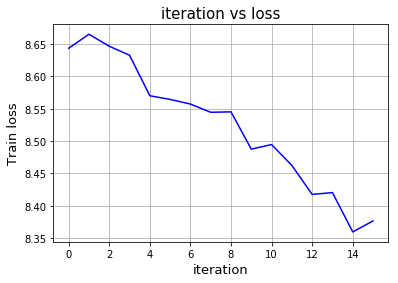

 70%|███████   | 7/10 [01:25<00:36, 12.19s/it]

Epoch 6: train loss 8.524209976196289, validation loss 8.278512954711914


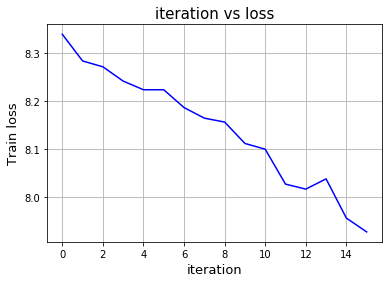

 80%|████████  | 8/10 [01:37<00:24, 12.22s/it]

Epoch 7: train loss 8.142023086547852, validation loss 7.912851333618164


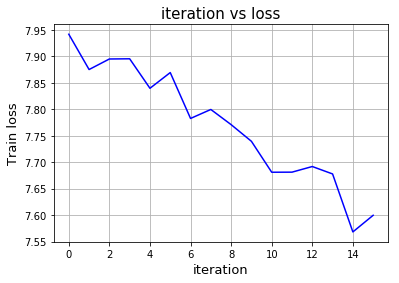

 90%|█████████ | 9/10 [01:50<00:12, 12.30s/it]

Epoch 8: train loss 7.769367218017578, validation loss 7.559364318847656


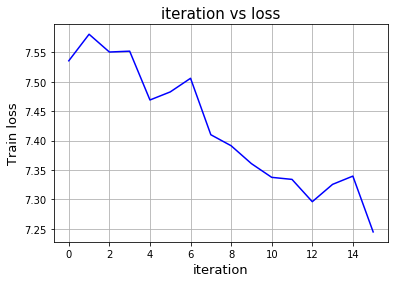

100%|██████████| 10/10 [02:02<00:00, 12.28s/it]

Epoch 9: train loss 7.419832706451416, validation loss 7.201520919799805


In [14]:
# run training mode
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    val_loss, tr_loss, tr_pred, val_pred, embeddings \
            = model.train(sess, (input_frames_train, captions_train), verbose = True)

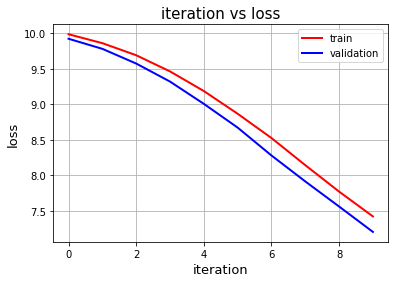

In [15]:
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/caption_learning_curve.png')

In [16]:
# check one caption
batch_size = 10
idx = np.random.randint(batch_size)
sample = val_pred[idx]
words = []
embed_train = False # whether train embedding word
print('sample: ', sample)
# caption
for i in sample:
    word = index2Word[i]
    words.append(word)
# # nearest neighbor searching
# for i in range(20):
#     best_error = float('inf')
#     word_vec = sample[i]
#     print('Word vec :', word_vec.shape)
#     if embed_train:
#         for row in range(embeddings.shape[0]):
#             vec = embeddings[row]
#             word = index2Word[row]
#             if np.sum(vec) == 0: continue
#             error = np.sum(np.square(word_vec - vec))
#             if error < best_error:
#                 w = word
#                 best_error = error
#     else:
#         for word, vec in word_dict.items():
#             if len(vec) == 0: continue
#             error = np.sum(np.square(word_vec - vec))
#             if error < best_error:
#                 w = word
#                 best_error = error
#     words.append(w)
    
print('Test Caption: ', ' '.join(w for w in words))

sample:  [266 266 266 266 266 266 266 266 266 266 266 266 266 266 266 266 266 266
 266 266]
Test Caption:  <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


In [11]:
len(sample)

20

In [15]:
for batch in minibatches(input_frames_train, captions_train, 50, 20):
    inp, cap = batch
    print('Captions: ', cap)
    raise

Captions:  [[   265.    270.  22428.   5190.    908.    270.  12062.  18103.    266.
     266.    266.    266.    266.    266.    266.    266.    266.    266.
     266.    266.]
 [   265.    270.  12062.  10561.   9553.   9695.   5190.  22215.  13945.
   19689.   9539.    266.    266.    266.    266.    266.    266.    266.
     266.    266.]
 [   265.  12062.   9617.    270.   9602.  19219.    266.    266.    266.
     266.    266.    266.    266.    266.    266.    266.    266.    266.
     266.    266.]
 [   265.    270.  22648.  11019.  10561.  11936.  13778.  20275.   3214.
     266.    266.    266.    266.    266.    266.    266.    266.    266.
     266.    266.]
 [   265.  12062.  13821.  19131.  16522.   1602.    266.    266.    266.
     266.    266.    266.    266.    266.    266.    266.    266.    266.
     266.    266.]
 [   265.    270.  12062.  10855.    908.  20678.  20275.  21414.  18003.
   13695.    270.   1562.    266.    266.    266.    266.    266.    266.
     2

RuntimeError: No active exception to reraise